In [78]:
import warnings
warnings.filterwarnings('ignore')

In [79]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score

import numpy as np
import scipy
import re

import matplotlib.pyplot as plt
%matplotlib inline

import collections

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader

import copy
import traceback
import datetime

# import dlnlputils
# from dlnlputils.data import tokenize_text_simple_regex, tokenize_corpus, build_vocabulary, \
#     vectorize_texts, SparseFeaturesDataset
# from dlnlputils.pipeline import train_eval_loop, predict_with_model, init_random_seed

# init_random_seed()



# Предподготовка текстов и признаков

In [80]:
train_source = fetch_20newsgroups(subset='train')
test_source = fetch_20newsgroups(subset='test')

In [81]:
print(f'Количество обучающих текстов {len(train_source['data'])}')
print(f'Количество тестовых текстов {len(test_source['data'])}')

Количество обучающих текстов 11314
Количество тестовых текстов 7532


In [82]:
print(train_source['data'][0].strip())

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----


In [83]:
print(f'Метка {train_source['target'][0]}')

Метка 7


## Подготовка признаков

In [84]:
TOKEN_RE = re.compile(r'[\w\d]+')

def tokenize_text_simpleregex(txt, min_token_size=4):
    txt = txt.lower()
    all_tokens = TOKEN_RE.findall(txt)
    return [token for token in all_tokens if len(token) >= min_token_size]


def tokenize_corpus(texts, tokenizer=tokenize_text_simpleregex, **tokenizer_kwargs):
    return [tokenizer(text, **tokenizer_kwargs) for text in texts]

In [85]:
train_tokenized = tokenize_corpus(train_source['data'])
test_tokenized = tokenize_corpus(test_source['data'])

In [86]:
print(' '.join(train_tokenized[0]))

from lerxst where thing subject what this nntp posting host rac3 organization university maryland college park lines wondering anyone there could enlighten this other door sports looked from late early called bricklin doors were really small addition front bumper separate from rest body this know anyone tellme model name engine specs years production where this made history whatever info have this funky looking please mail thanks brought your neighborhood lerxst


In [87]:
def build_vocabulary(tokenized_texts: list[list], max_size: int = 1000000, max_doc_freq: float = 0.8, min_count: int = 5, pad_word = None):
    word_counts = collections.defaultdict(int)
    doc_n = 0

    # посчитать количество документов, в которых употребляется каждое слово, а также количество документов
    for txt in tokenized_texts:
        doc_n += 1
        unique_text_tokens = set(txt)
        for token in unique_text_tokens:
            word_counts[token] += 1

    # удалить слишком редкие и слишком частые слова
    word_counts = {word : cnt for word, cnt in word_counts.items() 
                   if cnt >= min_count and cnt / doc_n <= max_doc_freq}
    
    # отсортируем слова по убыванию частоты
    sorted_word_couts = sorted(word_counts.items(), reverse=True, key=lambda pair: pair[1])

    # добавим несуществующее слово с индексом 0 для удобства пакетной обработки
    if pad_word is not None:
        sorted_word_couts = [(pad_word, 0)] + sorted_word_couts

    # если у нас по-прежнему слишком много слов, оставить только max_size самых частых слов
    if len(word_counts) > max_size:
        sorted_word_couts = sorted_word_couts[:max_size]
    
    # нумеруем слова
    word2id = {word: i for i, (word, _) in enumerate(sorted_word_couts)}

    # нормируем частоты слов
    word2freq = np.array([cnt / doc_n for _, cnt in sorted_word_couts], dtype='float32')

    return word2id, word2freq
        



In [191]:
MAX_DF = 0.8
MIN_COUNT = 5

vocabulary, word_doc_freq = build_vocabulary(train_tokenized, 
                                             max_doc_freq=MAX_DF, 
                                             min_count=MIN_COUNT)

UNIQUE_WORDS_N = len(vocabulary)

print(f'Количество уникальных токенов {UNIQUE_WORDS_N}')

Количество уникальных токенов 0


In [89]:
print(list(vocabulary.items())[:10])

[('that', 0), ('this', 1), ('have', 2), ('with', 3), ('writes', 4), ('article', 5), ('posting', 6), ('host', 7), ('nntp', 8), ('there', 9)]


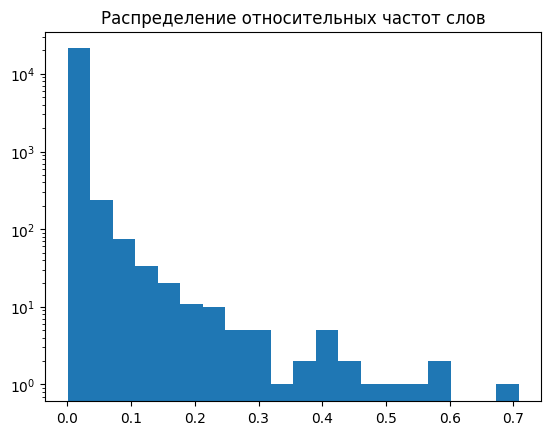

In [90]:
plt.hist(word_doc_freq, bins=20)
plt.title("Распределение относительных частот слов")
plt.yscale('log')

In [91]:
def vectorize_texts(tokenized_texts, word2id, word2freq, mode='tfidf', scale=True):
    assert mode in {'tfidf', 'idf', 'tf', 'bin'}

    # считаем количество употреблений каждого слова в каждом документе
    result = scipy.sparse.dok_matrix((len(tokenized_texts), len(word2id)), dtype='float32')
    for text_i, text in enumerate(tokenized_texts):
        for token in text:
            if token in word2id:
                result[text_i, word2id[token]] += 1

    # получаем бинарные вектора "встречается или нет"
    if mode == 'bin':
        result = (result > 0).astype('float32')

    # получаем вектора относительных частот слов в документы
    elif mode == 'tf':
        result = result.tocsr() # формат csr обеспечивает эффективные операции над строками матриц (но не эффективен для операций над столбцами)
        result = result.multiply(1 / result.sum(1))

    # полностью убираем информацию о количестве употребления слова в данном документе,
    # но оставляем информацию о частотности слов в корпусе в целом
    elif mode == 'idf':
        result = (result > 0).astype('float32').multiply(1 / word2freq)

    # учитываем всю информацию которая есть:
    # частоту слова в документе и частоту слов в корпусе
    elif mode == 'tfidf':
        result = result.tocsr()
        result = result.multiply(1 / result.sum(1)) # разделить каждую строку на ее длину
        result = result.multiply(1 / word2freq) # разделтить каждый столбец на вес слова

    if scale:
        result = result.tocsc()
        result -= result.min()
        result /= (result.max() + 1e-6)

    return result.tocsr()

In [92]:
VECTORIZATION_MODE = 'tfidf'

train_vectors = vectorize_texts(train_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE)
test_vectors = vectorize_texts(test_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE)


In [93]:
print(f'Размерность матрицы признаков обучающей выборки - {train_vectors.shape}')
print(f'Размерность матрицы признаков тестовой выборки - {test_vectors.shape}')

Размерность матрицы признаков обучающей выборки - (11314, 21628)
Размерность матрицы признаков тестовой выборки - (7532, 21628)


In [94]:
print('Количество ненулевых элементов в обучающей выборке', train_vectors.nnz)

Количество ненулевых элементов в обучающей выборке 1126792


In [95]:
percent = round(train_vectors.nnz * 100 / (train_vectors.shape[0] * train_vectors.shape[1]) , 2)
print(f'Процент заполеннности мастрицы признаков в трейне {percent}%')

Процент заполеннности мастрицы признаков в трейне 0.46%


In [96]:
print(f'Количество ненулевых  элементов в трейне {train_vectors.nnz}')

Количество ненулевых  элементов в трейне 1126792


In [97]:
percent = round(test_vectors.nnz * 100 / (test_vectors.shape[0] * test_vectors.shape[1]) , 2)
print(f'Процент заполеннности мастрицы признаков в трейне {percent}%')

Процент заполеннности мастрицы признаков в трейне 0.44%


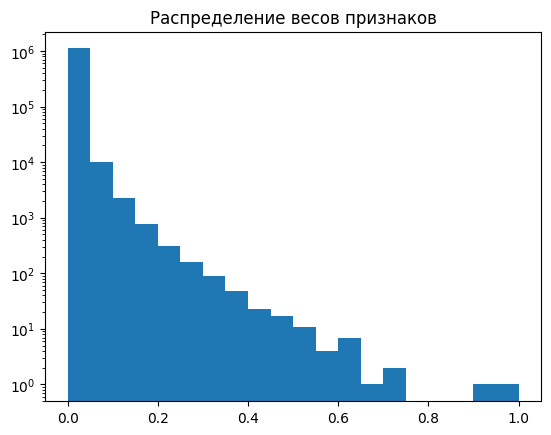

In [98]:
plt.hist(train_vectors.data, bins=20)
plt.title('Распределение весов признаков')
plt.yscale('log')

# Распределение классов

In [99]:
UNIQUE_LABELS_N = len(set(train_source['target']))

print(f'Количество уникальных меток {UNIQUE_LABELS_N}')

Количество уникальных меток 20


Text(0.5, 1.0, 'Распределение меток в обучающей выборке')

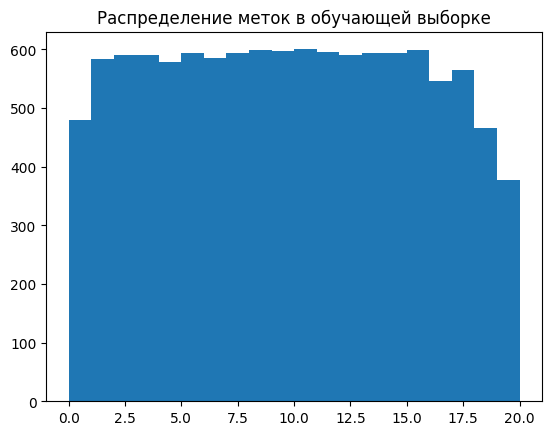

In [100]:
plt.hist(train_source['target'], bins=np.arange(0, 21))
plt.title('Распределение меток в обучающей выборке')

Text(0.5, 1.0, 'Распределение меток в тестовой выборке')

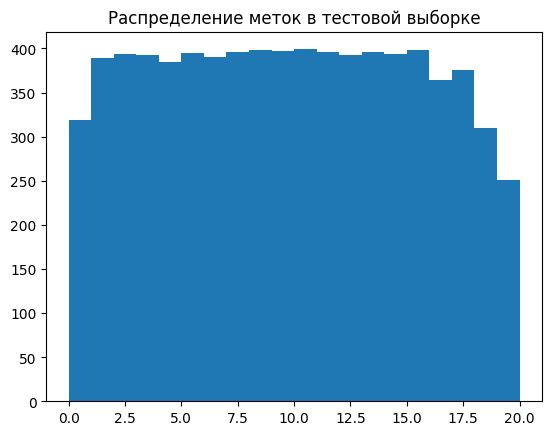

In [101]:
plt.hist(test_source['target'], bins=np.arange(0, 21))
plt.title('Распределение меток в тестовой выборке')

In [102]:
from torch.utils.data import Dataset


In [159]:
class SparseFeaturesDataset(Dataset):

    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return self.features.shape[0]
    
    def __getitem__(self, idx):
        """
        Данный метод нужен так как весь датасет - это разреженная матрица, а pytorch с такими матрицами не работает.
        """
        cur_features = torch.from_numpy(self.features[idx].toarray()[0]).float()
        cur_label = torch.from_numpy(np.asarray(self.targets[idx])).long()
        print(cur_features.size())
        print(cur_label.size())
        return cur_features, cur_label

# Модель

In [160]:
def train_eval_loop(model: torch.nn.Module, train_dataset: torch.utils.data.Dataset, 
                    val_dataset: torch.utils.data.Dataset, criterion,
                    lr: float = 1e-4, epoch_n: int = 10, batch_size: int = 32, 
                    device: str = 'cuda', early_stopping_patience: int = 10, l2_reg_alpha: int = 0,
                    max_batches_per_epochs_train: int = 10000, 
                    max_batches_per_epochs_val: int = 1000,
                    data_loader_ctor=DataLoader,
                    optimizer_ctor=None,
                    lr_scheduler_cror=None,
                    shuffle_train=True):
    
    """
    Цикл обученяия модели. После каждой эпохи качество модели оценивается по отложенной выборке
    :param model: torch.nn.Module - модель обучения,
    :param train_dataset: torch.utils.data.Dataset - данные для обучения,
    :param val_dataset: torch.utils.data.Dataset - данные для валидации,
    :param criterion: функция потерб для настройки модели,
    :param lr: float - скорость обучения,
    :param epoch_n: int - максимальное количество эпох обучения,
    :param batch_size: int - количество примеров, которые обрабытывает модель за одну итерацию,
    :param device: cuda/cpu - устройство, на котором выполняется вычисление,
    :param early_stopping_patience: наибольшее количество эпох, в течение которых допускается отсутствие улучшения модели, чтобы обучение продолжалеось,
    :param l2_reg_alpha: коэффициент L2-регуляризации,
    :param max_batches_per_epochs_train: int - максимальное количество итераций на одну эпоху обученния,
    :param max_batches_per_epochs_val: int - максимальное количество итераций на одну эпоху валидации,



    """

    device = torch.device(device)
    model.to(device)

    if optimizer_ctor is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_reg_alpha)
    else:
        optimizer = optimizer_ctor(model.parameters(), lr=lr)

    if lr_scheduler_cror is not None:
        lr_scheduler = lr_scheduler_cror(optimizer)
    else:
        lr_scheduler = None

    train_data_loader = data_loader_ctor(train_dataset, batch_size=batch_size, shuffle=shuffle_train)
    val_dataloader = data_loader_ctor(val_dataset, batch_size=batch_size, shuffle=shuffle_train)

    best_val_loss = float('inf')
    best_epoch_i = 0
    best_model = copy.deepcopy(model)

    for epoch_i in range(epoch_n):
        try:
            epoch_start = datetime.datetime.now()
            print(f'Эпоха {epoch_i}')

            model.train()
            mean_train_loss = 0
            train_batches_n = 0
            for batch_i, (batch_x, batch_y) in enumerate(train_data_loader):
                if batch_i > max_batches_per_epochs_train:
                    break

                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)

                pred = model(batch_x)
                loss = criterion(pred, batch_y)

                model.zero_grad()
                loss.backward()
                optimizer.step()

                mean_train_loss += float(loss)
                train_batches_n += 1

            mean_train_loss /= train_batches_n
            print(f'Эпоха {batch_i}, {(datetime.datetime.now() - epoch_start).total_seconds()}')
            print(f'Среднее значение функции потерь {mean_train_loss}')

            model.eval()
            mean_val_loss = 0
            val_batches_n = 0

            with torch.no_grad():
                for batch_i, (batch_x, batch_y) in enumerate(val_dataloader):
                    if batch_i > max_batches_per_epochs_val:
                        break

                    batch_x = batch_x.to(device)
                    batch_y = batch_y.to(device)

                    pred = model(batch_x)
                    loss = criterion(pred, batch_y)

                    mean_val_loss += float(loss)
                    val_batches_n += 1

            mean_val_loss /= val_batches_n
            print(f'Среднее значение функции потерь на валидации {mean_val_loss}')

            if mean_val_loss < best_val_loss:
                best_epoch_i = epoch_i
                best_val_loss = mean_val_loss
                best_model = copy.deepcopy(model)
                print('Новая лучшая модель!')
            elif epoch_i - best_epoch_i > early_stopping_patience:
                print(f'Модель не улучшилась за последние {early_stopping_patience} эпох, прекращаем обучение.')
                break

            if lr_scheduler is not None:
                lr_scheduler.step(mean_val_loss)

            print()
        except KeyboardInterrupt:
            print('Обучение досрочно остановлено пользователем')
            break
        except Exception as ex:
            print(f'Ошибка в обучении: {ex}/{traceback.format_exc()}')
            break
    
    return best_val_loss, best_model


In [161]:
train_dataset = SparseFeaturesDataset(train_vectors, train_source['target'])
test_dataset = SparseFeaturesDataset(test_vectors, test_source['target'])

In [ ]:
inputs = test_dataset.__getitem__(1)[0]
output = test_dataset.__getitem__(1)[1]

torch.Size([21628])
torch.Size([])
torch.Size([21628])
torch.Size([])


In [184]:
model = nn.Linear(21628, 1)

output = model(inputs)
print(output.size())

torch.Size([1, 1])


In [176]:
output.size()

torch.Size([])

In [186]:
batch_size = 32
model = nn.Linear(32, UNIQUE_WORDS_N, 1)

def lr_scheduler(optim):
    return torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=5, factor=0.5)


best_val_loss, best_model = train_eval_loop(model=model, 
                                            train_dataset=train_dataset, 
                                            val_dataset=test_dataset,
                                            criterion=F.cross_entropy,
                                            lr=1e-1,
                                            epoch_n=200,
                                            batch_size=32,
                                            l2_reg_alpha=0,
                                            lr_scheduler_cror=lr_scheduler)



Эпоха 0
torch.Size([21628])
torch.Size([])
torch.Size([21628])
torch.Size([])
torch.Size([21628])
torch.Size([])
torch.Size([21628])
torch.Size([])
torch.Size([21628])
torch.Size([])
torch.Size([21628])
torch.Size([])
torch.Size([21628])
torch.Size([])
torch.Size([21628])
torch.Size([])
torch.Size([21628])
torch.Size([])
torch.Size([21628])
torch.Size([])
torch.Size([21628])
torch.Size([])
torch.Size([21628])
torch.Size([])
torch.Size([21628])
torch.Size([])
torch.Size([21628])
torch.Size([])
torch.Size([21628])
torch.Size([])
torch.Size([21628])
torch.Size([])
torch.Size([21628])
torch.Size([])
torch.Size([21628])
torch.Size([])
torch.Size([21628])
torch.Size([])
torch.Size([21628])
torch.Size([])
torch.Size([21628])
torch.Size([])
torch.Size([21628])
torch.Size([])
torch.Size([21628])
torch.Size([])
torch.Size([21628])
torch.Size([])
torch.Size([21628])
torch.Size([])
torch.Size([21628])
torch.Size([])
torch.Size([21628])
torch.Size([])
torch.Size([21628])
torch.Size([])
torch.Size([

In [ ]:
def predict_with_model(model: torch.nn.Module, 
                       dataset: torch.utils.data.Dataset, 
                       device: str ='cuda', batch_size: int = 32):
    """
    :param model: torch.nn.Module - обученная модель,
    :param dataset: torch.utils.data.Dataset - данные для применения модели,
    :param device: str - cuda/cpu - устройство, на котором выполняется вычисление,
    :param batch_size: int - количество примеров, обрабатываемых моделью за одну имтерацию,
    :return: numpy.array размерности len(dataset)
    """
    results_by_batch = []

    device = torch.device(device)
    model.to(device)
    model.eval()

    dataloader = DataLoader(dataset, batch_size, shuffle=False)
    with torch.no_grad():
        for batch_x, batch_y in dataloader:
            batch_x = batch_x.to(device)

            batch_pred = model(batch_x)
            results_by_batch.append(batch_pred.detach().cpu().numpy())

    return np.concatenate(results_by_batch, 0)

# Оценка качества

In [ ]:
train_pred = predict_with_model(best_model, train_dataset)
train_loss = F.cross_entropy(torch.from_numpy(train_pred),
                             torch.from_numpy(train_source['target']))
print(f'Среднее значение функции потерь на обучении {float(train_loss)}')
print(f'Доля верных ответов {accuracy_score(train_source['target'],
                                            train_pred.argmax(-1))}')
print('--------------------------------------------------------------')
test_pred = predict_with_model(best_model, test_dataset)
test_loss = F.cross_entropy(torch.from_numpy(test_pred), 
                            torch.from_numpy(test_source['target']))
print(f'Среднее значение функции потерь на валидации {float(test_loss)}')
print(f'Доля верных ответов {accuracy_score(test_source['target'], test_pred.argmax(-1))}')

# Альтернативная реализация на scikit-learn

In [188]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

In [193]:
MAX_DF = 0.8
MIN_COUNT = 5

sklearn_pipeline = Pipeline((('vect', TfidfVectorizer(tokenizer=tokenize_text_simpleregex,
                                                      max_df=MAX_DF,
                                                      min_df=MIN_COUNT)),
                            ('cls', LogisticRegression())))


In [194]:
sklearn_pipeline.fit(test_source['data'], train_source['target'])

ValueError: Found input variables with inconsistent numbers of samples: [7532, 11314]

# Оценка качества

In [ ]:
sklearn_train_pred = sklearn_pipeline.predict_proba(train_source['data'])
sklearn_train_loss = F.cross_entropy(torch.from_numpy(sklearn_train_pred), 
                                     torch.from_numpy(train_source['target']))
print(f'Среднее знаение функции потерь на обучении {float(sklearn_train_loss)}')
print(f'Доля верных ответов {accuracy_score(train_source['target'], sklearn_train_pred.argmax(-1))}')
print('------------------------------------------------------------------------------------')

sklearn_test_pred = sklearn_pipeline.predict_proba(test_source['data'])
sklearn_test_loss = F.cross_entropy(torch.from_numpy(sklearn_test_pred),
                                    torch.from_numpy(test_source['target']))
print(f'Среднее значение функции потерь на валидации {float(sklearn_test_loss)}')
print(f'Доля верных ответов {accuracy_score(test_source['target'], sklearn_test_pred(-1))}')


In [177]:
m = nn.Linear(20, 30)
input = torch.randn(128, 20)
output = m(input)
print(output.size())

torch.Size([128, 30])


In [179]:
input.size()

torch.Size([128, 20])